<a href="https://colab.research.google.com/github/Abhishekkk2004/Deepseek-from-Scratch/blob/main/MixtureOfExpertsFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch. manual_seed (42)
#Optional

## Define each Expert as Neural Network


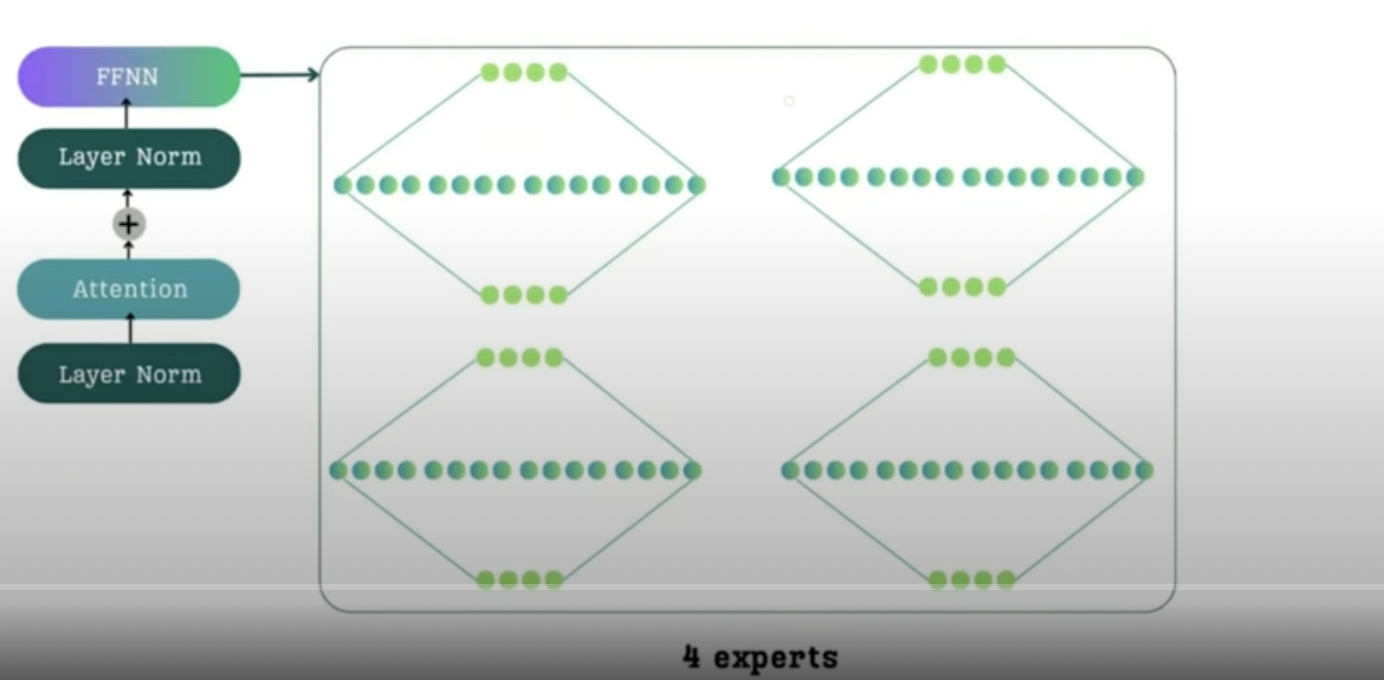

In [3]:
#Expert module
class Expert(nn.Module):
  """ MLP is a simple linear layer followed my non-linearity (An Expert)"""

  def __init__(self,n_embd):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear( n_embd, 4 * n_embd),
      nn.ReLU(),
      nn.Linear( 4 * n_embd, n_embd),
      nn.Dropout(dropout),
    )

  def forward(self,x):
    return self.net(x)

## Creating the Route Matrix

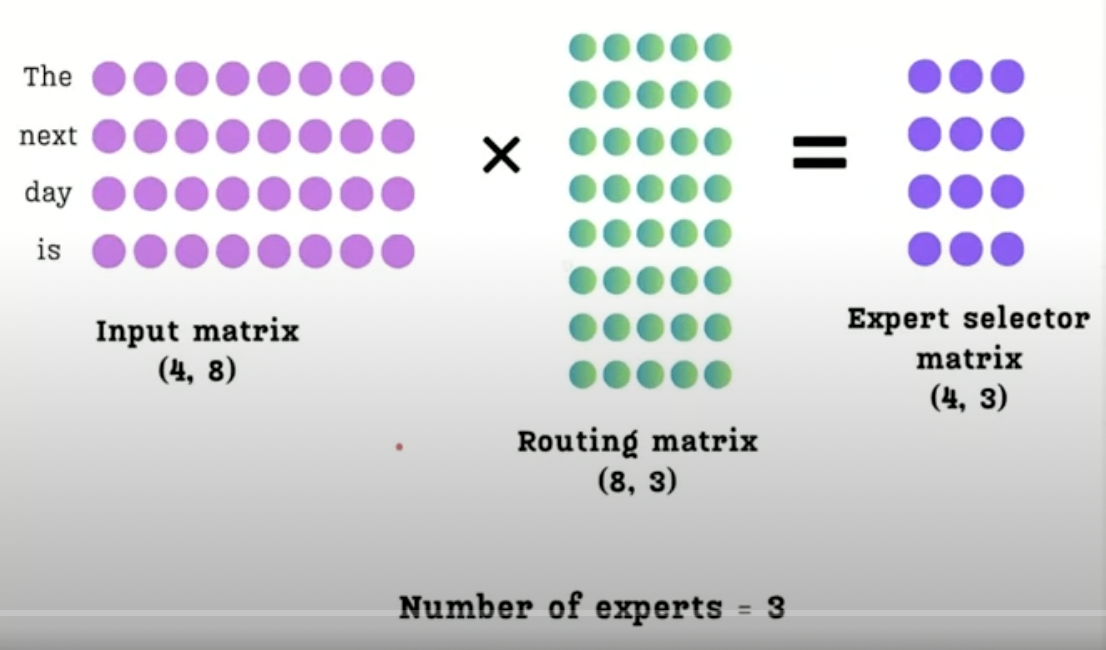

The Routing matrix decides which Expert recieves which tokes which come from MHA


In [5]:
#Understanding how gating works
num_experts = 3
top_k=2
n_embed=8


#Example multi-head attention output for a simple illustrative example,
mh_output = torch.randn(1, 4, n_embed)

topkgate_linear = nn.Linear(n_embed, num_experts) # nn. Linear (32, 4)
logits = topkgate_linear (mh_output)
print (logits)
print (logits.shape)

tensor([[[-0.1959, -0.8689, -0.6757],
         [ 0.3530, -0.2421, -1.3216],
         [-0.5338, -0.0048,  0.5704],
         [ 0.5119,  0.2441, -0.4035]]], grad_fn=<ViewBackward0>)
torch.Size([1, 4, 3])


## Implementing top-K sampling

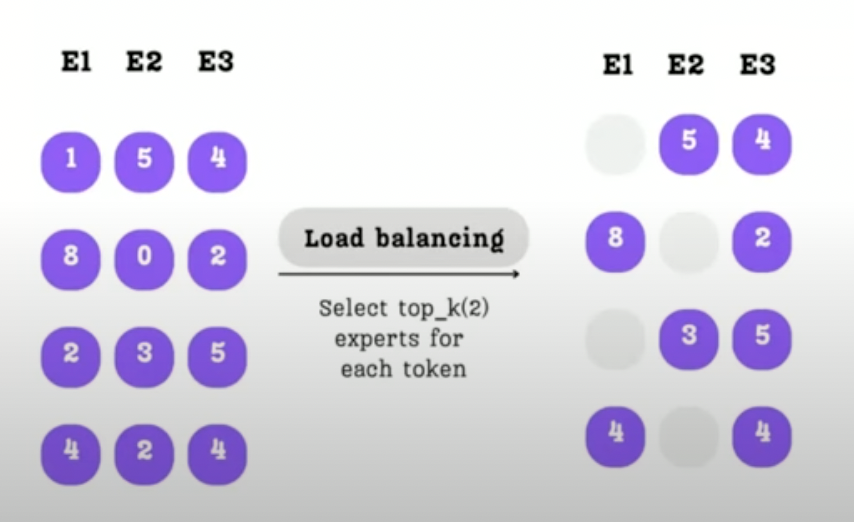

In [6]:
top_k_logits, top_k_indices = logits.topk(top_k, dim=-1) # Get top-k experts
top_k_logits, top_k_indices

(tensor([[[-0.1959, -0.6757],
          [ 0.3530, -0.2421],
          [ 0.5704, -0.0048],
          [ 0.5119,  0.2441]]], grad_fn=<TopkBackward0>),
 tensor([[[0, 2],
          [0, 1],
          [2, 1],
          [0, 1]]]))

## Applying -inf and then softmax

In [7]:
zeros = torch.full_like(logits, float('-inf')) #full_like clone
sparse_logits = zeros.scatter(-1, top_k_indices, top_k_logits)
sparse_logits

tensor([[[-0.1959,    -inf, -0.6757],
         [ 0.3530, -0.2421,    -inf],
         [   -inf, -0.0048,  0.5704],
         [ 0.5119,  0.2441,    -inf]]], grad_fn=<ScatterBackward0>)

In [8]:
gating_output= F.softmax(sparse_logits, dim=-1)
gating_output

tensor([[[0.6177, 0.0000, 0.3823],
         [0.6445, 0.3555, 0.0000],
         [0.0000, 0.3600, 0.6400],
         [0.5666, 0.4334, 0.0000]]], grad_fn=<SoftmaxBackward0>)

## Create a class for top-K routing

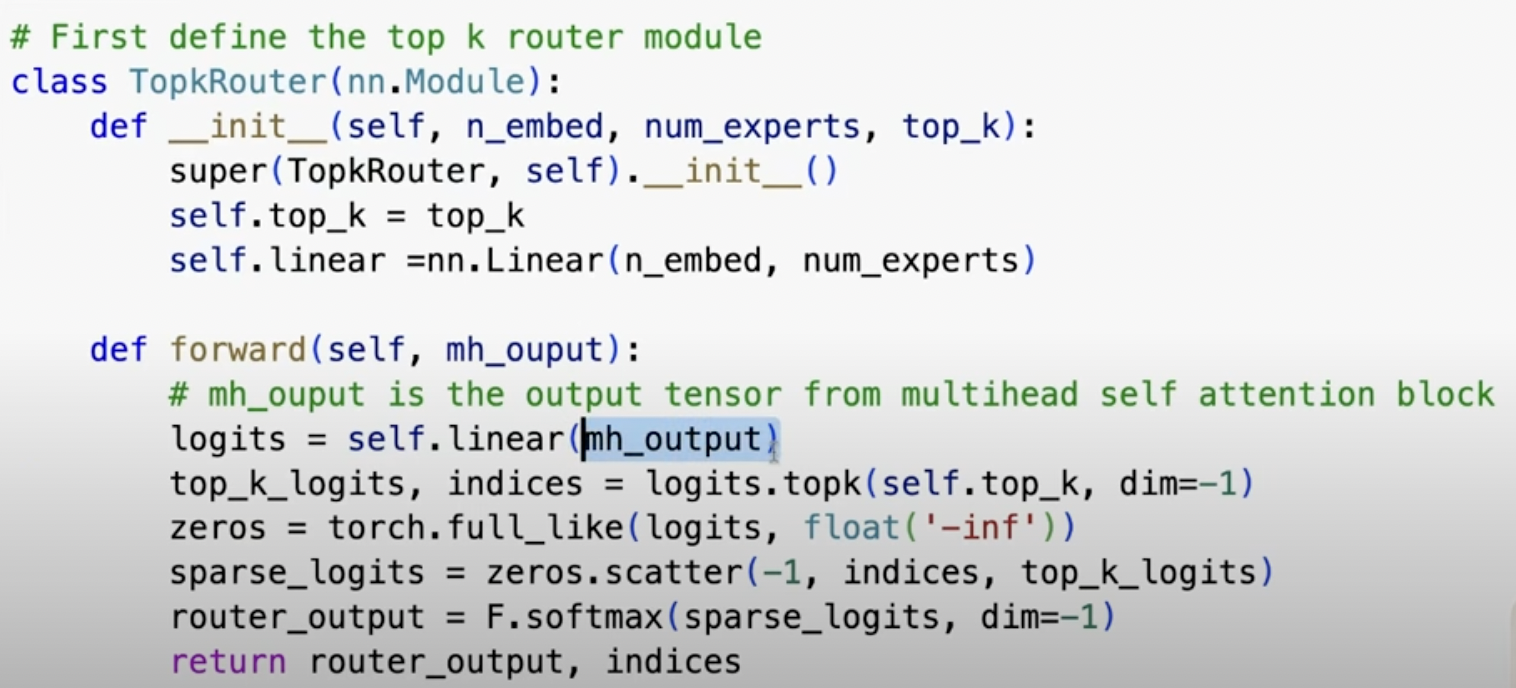

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TopkRouter(nn.Module):
    def __init__(self, n_embed, num_experts, top_k):
        super(TopkRouter, self).__init__()
        self.n_embed = n_embed
        self.num_experts = num_experts
        self.top_k = top_k
        self.linear = nn.Linear(n_embed, num_experts)

    def forward(self, mh_output):
        logits = self.linear(mh_output)  # shape: [B, L, num_experts]
        top_k_logits, indices = logits.topk(self.top_k, dim=-1)  # shape: [B, L, top_k]

        zeros = torch.full_like(logits, float('-inf'))  # shape: [B, L, num_experts]
        sparse_logits = zeros.scatter(-1, indices, top_k_logits)  # only top_k kept
        router_output = F.softmax(sparse_logits, dim=-1)  # softmax over top_k positions

        return router_output, top_k_logits, indices


In [20]:
#Testing this out:
num_experts = 3
top_k = 2
n_embd = 8
mh_output = torch. rand(1, 4, n_embd) # Example input
top_k_gate = TopkRouter(n_embd, num_experts, top_k)
gating_output, top_k_logits, indices = top_k_gate(mh_output)
print("Gating output shape:", gating_output.shape)
print("Gating output:\n", gating_output)
print("Top-k indices:\n", indices)
#And it works!!

Gating output shape: torch.Size([1, 4, 3])
Gating output:
 tensor([[[0.0000, 0.5463, 0.4537],
         [0.0000, 0.4151, 0.5849],
         [0.0000, 0.3391, 0.6609],
         [0.0000, 0.3984, 0.6016]]], grad_fn=<SoftmaxBackward0>)
Top-k indices:
 tensor([[[1, 2],
         [2, 1],
         [2, 1],
         [2, 1]]])


## Creating a class for noisyTopK


In [21]:
#Changing the above to accomodate noisy top-k gating
class NoisyTopkRouter(nn.Module):
    def __init__(self, n_embed, num_experts, top_k):
        super(NoisyTopkRouter, self).__init__()
        self.top_k = top_k
        #layer for router logits
        self.topkroute_linear = nn.Linear(n_embed, num_experts)
        self.noise_linear =nn.Linear(n_embed, num_experts)


    def forward(self, mh_output):
        # mh_ouput is the output tensor from multihead self attention block
        logits = self.topkroute_linear(mh_output)

        #Noise logits
        noise_logits = self.noise_linear(mh_output)

        #Adding scaled unit gaussian noise to the logits
        noise = torch.randn_like(logits)*F.softplus(noise_logits)
        noisy_logits = logits + noise

        top_k_logits, indices = noisy_logits.topk(self.top_k, dim=-1)
        zeros = torch.full_like(noisy_logits, float('-inf'))
        sparse_logits = zeros.scatter(-1, indices, top_k_logits)
        router_output = F.softmax(sparse_logits, dim=-1)
        return router_output, indices


In [27]:
#Testing this out, again:
num_experts = 3
top_k = 2
n_embd = 8
mh_output = torch.randn(1, 4, n_embd) # Example input
noisy_top_k_gate = NoisyTopkRouter(n_embd, num_experts, top_k)
gating_output, indices = noisy_top_k_gate(mh_output)
gating_output. shape, gating_output, indices
#It works!!

(torch.Size([1, 4, 3]),
 tensor([[[0.0000, 0.1129, 0.8871],
          [0.2434, 0.0000, 0.7566],
          [0.7429, 0.2571, 0.0000],
          [0.9214, 0.0786, 0.0000]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[2, 1],
          [2, 0],
          [0, 1],
          [0, 1]]]))

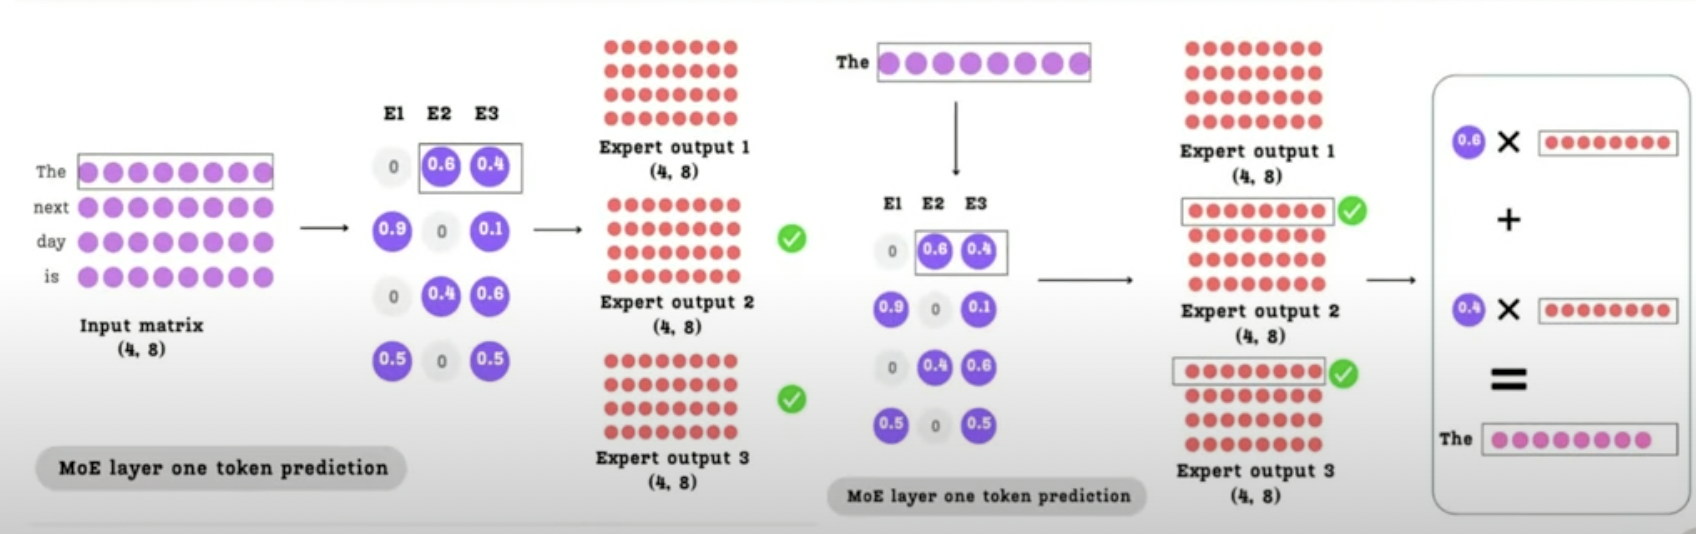

## Creating a Sparse MoE module

In [28]:
class SparseMoE(nn.Module):
    def __init__(self, n_embed, num_experts, top_k):
        super(SparseMoE, self).__init__()
        self.router = NoisyTopkRouter(n_embed, num_experts, top_k)
        self.experts = nn.ModuleList([Expert(n_embed) for _ in range(num_experts)])
        self.top_k = top_k

    def forward(self, x):
        gating_output, indices = self.router(x)
        final_output = torch.zeros_like(x)

        # Reshape inputs for batch processing
        flat_x = x.view(-1, x.size(-1))
        flat_gating_output = gating_output.view(-1, gating_output.size(-1))

        # Process each expert in parallel
        for i, expert in enumerate(self.experts):
            # Create a mask for the inputs where the current expert is in top-k
            expert_mask = (indices == i).any(dim=-1)
            flat_mask = expert_mask.view(-1)

            if flat_mask.any():
                expert_input = flat_x[flat_mask]
                expert_output = expert(expert_input)

                # Extract and apply gating scores
                gating_scores = flat_gating_output[flat_mask, i].unsqueeze(1)
                weighted_output = expert_output * gating_scores

                # Update final output additively by indexing and adding
                final_output[expert_mask] += weighted_output.squeeze(1)

        return final_output


In [31]:
import torch
import torch.nn as nn

#Let's test this out
num_experts = 4
top_k = 2
n_embd = 8
dropout=0.1

mh_output = torch.randn(1, 4, n_embd)  # Example multi-head attention output
sparse_moe = SparseMoE(n_embd, num_experts, top_k)
final_output = sparse_moe(mh_output)
print("Shape of the final output:", final_output.shape)
print("Shape of the final output:", final_output)


Shape of the final output: torch.Size([1, 4, 8])
Shape of the final output: tensor([[[-0.1221,  0.0303,  0.0840, -0.0508,  0.2013,  0.1280, -0.1170,
          -0.0566],
         [ 0.0204, -0.2002, -0.0269,  0.0291, -0.1436,  0.4359,  0.1958,
          -0.0438],
         [ 0.0598, -0.2588, -0.1391,  0.0490, -0.1541, -0.0112,  0.2067,
          -0.0163],
         [ 0.0034,  0.0972, -0.0800, -0.1551, -0.5097, -0.0936,  0.2723,
          -0.0346]]], grad_fn=<IndexPutBackward0>)
